# Modify the planetary emission model by using realistic stellar spectrum (generated using pandexo's function) instead of assuming it to be a blackbody

In [1]:
# import area

import numpy as np
from astropy.modeling import models
from astropy import units as u
import math
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib notebook
#for VSCode
%matplotlib inline
import time
#from numba import jit
#from pandexo.engine.bintools import binning
plt.rcParams['figure.dpi'] = 140
#import pandexo.engine.justdoit as jdi # THIS IS THE HOLY GRAIL OF PANDEXO
#import pandexo.engine.justplotit as jpi
#import pandexo.engine.create_input as create
import pysynphot as psyn
from spectres import spectres 


/Users/imishra/miniconda3/envs/rocky_exo/lib/python3.10/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/imishra/miniconda3/envs/rocky_exo/lib/python3.10/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


### Test the pandexo function that generates a stellar spectrum and compare it to a blackbody

In [6]:
star_dict = {}
star_dict['type'] = 'phoenix'        #phoenix or user (if you have your own)
star_dict['mag'] = 10.046            #magnitude of the system (obtained from SIMBAD)
star_dict['ref_wave'] = 1.25         #For J mag = 1.25, H = 1.6, K =2.22.. etc (all in micron)
#star_dict['temp'] = 3036            #in K
star_dict['temp'] = 3500             # minimum limit for pysynphot's ck04models grid
star_dict['metal'] = 0.0             # as log Fe/H (don't know this value)
#star_dict['logg'] = 5.06              #log surface gravity cgs (from ExoMAST)
star_dict['logg'] = 5.00             # maximum limit for pysynphot's ck04models grid


In [7]:
# star_spec = create.outTrans(star_dict)

sp = psyn.Icat("phoenix", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
stellar_wav_p = sp.wave
stellar_flux_p = sp.flux


sp = psyn.Icat("ck04models", star_dict['temp'], star_dict['metal'], star_dict['logg'])
sp.convert("m")
sp.convert("jy")
stellar_wav_c = sp.wave
stellar_flux_c = sp.flux



FileNotFoundError: [Errno 2] No such file or directory: 'grid/phoenix/catalog.fits'

In [5]:
## also try the NextGen (solar) model that Nikole recommended

data = np.loadtxt('Resources/LHS3844_nextgensolar_spectrum.txt', skiprows=7)
stellar_wav_n = data[:,0]
stellar_flux_n = data[:,1]

# convert wavelength axis to m

stellar_wav_n = stellar_wav_n*10**-10

# convert from erg/cm2/s/A to jy (10^-23 ergs/cm2/s/Hz)

c = 3.0e+8
stellar_flux_n = 10**23*stellar_flux_n*10**10*(stellar_wav_n)**2/c

In [159]:
stellar_flux_n

array([2.937940249631999e-90, 6.035071831474665e-90,
       1.1000506814364663e-89, ..., 25228216282854.266,
       22509606520003.867, 20197155090003.6], dtype=object)

In [160]:
stellar_flux_c

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.63409046e+15, 1.20035041e+15, 9.17968389e+14])

### Run Hu et al. model for basalt with a pandexo stellar spectrum v/s a blackbody stellar spectrum

(1e-06, 2.4999999999999998e-05)

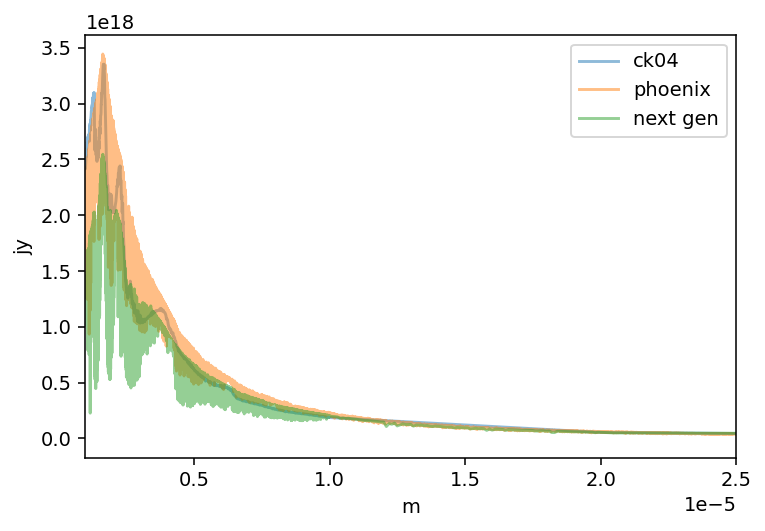

In [162]:
plt.figure()
#plt.plot(star_spec['wave'], star_spec['flux_out_trans'])
plt.plot(stellar_wav_c, stellar_flux_c, label='ck04', alpha=0.5)
plt.plot(stellar_wav_p, stellar_flux_p, label='phoenix', alpha=0.5)
plt.plot(stellar_wav_n, stellar_flux_n, label='next gen', alpha=0.5)
plt.xlabel('m')
plt.ylabel('jy')
plt.legend()
plt.xlim((1*10**-6,25*10**-6))
#plt.yscale('log')

Nikole recommended next gen models, so let us proceed with that

In [6]:
### Convert everything to SI (wavelength in m and flux density in W m^-2 Hz^-1)

#slice the arrays between 1 and 25 microns

stellar_wav = stellar_wav_n
stellar_flux = stellar_flux_n

ind = np.where((stellar_wav > 1.0*10**-6) & (stellar_wav < 25.0*10**-6))
stellar_wav = stellar_wav[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
stellar_spec_grid = stellar_flux[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
stellar_spec_grid = stellar_spec_grid*c/(stellar_wav)**2

### compare to black body flux

def bb(wav,T):
    pi = np.pi
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity


stellar_spec_bb = bb(stellar_wav, star_dict['temp']) 

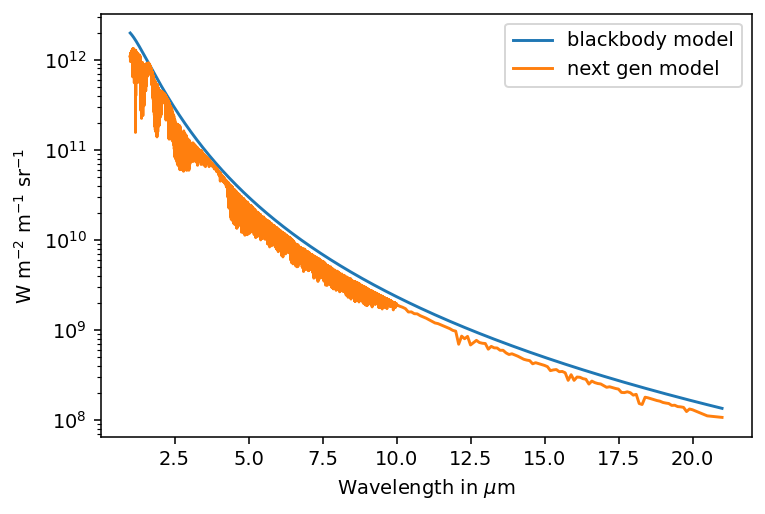

In [9]:
plt.figure()
plt.plot(stellar_wav*10**6, stellar_spec_bb, label='blackbody model')
# convert flux density to radiance
plt.plot(stellar_wav*10**6, stellar_spec_grid/np.pi, label='next gen model')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('W m$^{-2}$ m$^{-1}$ sr$^{-1}$')
plt.legend()
#plt.xlim((5,25))
plt.yscale('log')

Text(0.5, 1.0, 'BB model / Nextgen model')

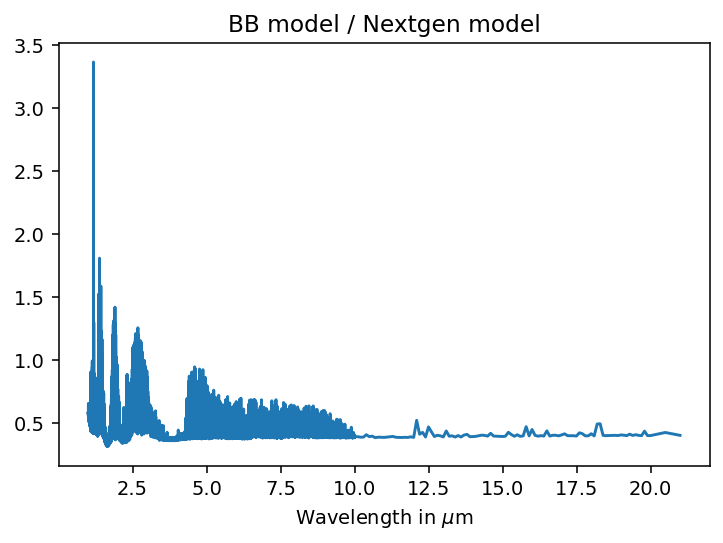

In [168]:
plt.figure()
plt.plot(stellar_wav*10**6, stellar_spec_bb/stellar_spec_grid)
plt.xlabel('Wavelength in $\mu$m')
#plt.ylabel('W m$^{-2}$ m$^{-1}$ sr$^{-1}$')
plt.title('BB model / Nextgen model')

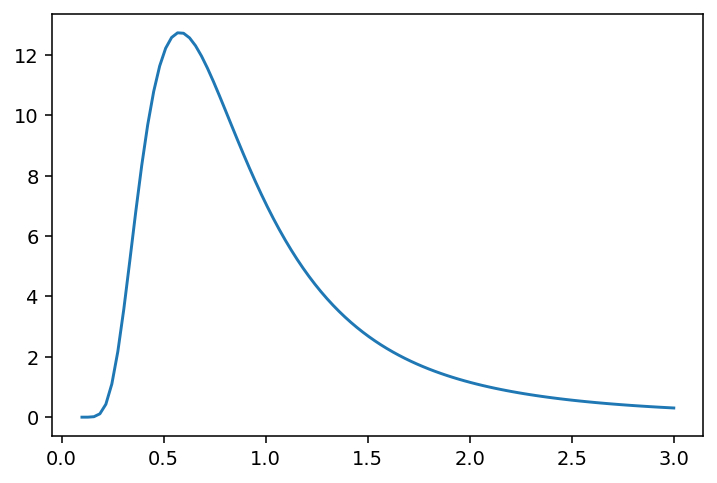

In [65]:
wav = np.linspace(0.1, 3, num=100) # microns
bb_spec = bb(wav*10**-6, 5000)

plt.figure()
plt.plot(wav, bb_spec*10**-9*10**-3)

In [66]:
bb_spec

array([3.67338446e+06, 6.94735691e+08, 1.53395006e+10, 1.11637757e+11,
       4.27975203e+11, 1.09997888e+12, 2.17158740e+12, 3.57488032e+12,
       5.17060093e+12, 6.80289948e+12, 8.33846936e+12, 9.68392610e+12,
       1.07871027e+13, 1.16299826e+13, 1.22190033e+13, 1.25759155e+13,
       1.27305018e+13, 1.27153851e+13, 1.25626603e+13, 1.23019293e+13,
       1.19593242e+13, 1.15571825e+13, 1.11141185e+13, 1.06453169e+13,
       1.01629289e+13, 9.67650041e+12, 9.19338759e+12, 8.71913788e+12,
       8.25782603e+12, 7.81234263e+12, 7.38463729e+12, 6.97592024e+12,
       6.58682768e+12, 6.21755600e+12, 5.86796976e+12, 5.53768786e+12,
       5.22615191e+12, 4.93267991e+12, 4.65650821e+12, 4.39682392e+12,
       4.15278982e+12, 3.92356309e+12, 3.70830937e+12, 3.50621304e+12,
       3.31648446e+12, 3.13836498e+12, 2.97113020e+12, 2.81409175e+12,
       2.66659814e+12, 2.52803480e+12, 2.39782349e+12, 2.27542135e+12,
       2.16031967e+12, 2.05204242e+12, 1.95014467e+12, 1.85421096e+12,
      

### Generate $F_p/F_*$ models with blackbody stellar spectrum and grid stellar spectrum and compare

#### Compare BB star spectrum to stellar

In [8]:
## Load the NextGen (solar) model that Nikole recommended

data = np.loadtxt('Resources/LHS3844_nextgensolar_spectrum.txt', skiprows=7)
stellar_wav_n = data[:,0]
stellar_flux_n = data[:,1]

# convert wavelength axis to m

stellar_wav_n = stellar_wav_n*10**-10

# convert from erg/cm2/s/A to jy (10^-23 ergs/cm2/s/Hz)

c = 3.0e+8
stellar_flux_n = 10**23*stellar_flux_n*10**10*(stellar_wav_n)**2/c

### Convert everything to SI (wavelength in m and flux density in W m^-2 Hz^-1)

#slice the arrays between 1 and 25 microns

stellar_wav = stellar_wav_n
stellar_flux = stellar_flux_n

ind = np.where((stellar_wav > 1.0*10**-6) & (stellar_wav < 25.0*10**-6))
stellar_wav = stellar_wav[ind] # in meters

# the input flux density unit is Jy = 10^-26 W m^-2 Hz^-1
stellar_spec_grid = stellar_flux[ind]*10**-26  # in W m^-2 Hz^-1

# Now convert it to per unit wavelength

c = 3.0e+8
stellar_spec_grid = stellar_spec_grid*c/(stellar_wav)**2

# convert from flux density to spectral radiance

stellar_spec_grid = stellar_spec_grid/np.pi

### compare to black body flux

def bb(wav,T):
    pi = np.pi
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity


stellar_spec_bb = bb(stellar_wav, 3036) 

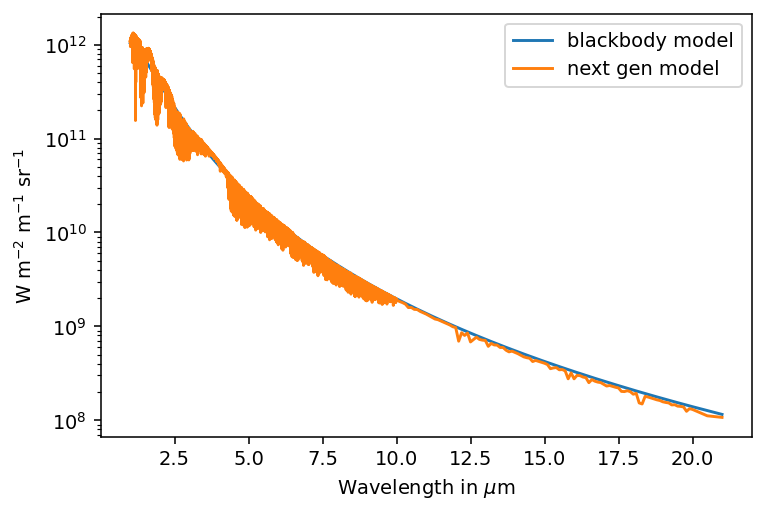

In [9]:
plt.figure()
plt.plot(stellar_wav*10**6, stellar_spec_bb, label='blackbody model')
# convert flux density to radiance
plt.plot(stellar_wav*10**6, stellar_spec_grid, label='next gen model')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('W m$^{-2}$ m$^{-1}$ sr$^{-1}$')
plt.legend()
#plt.xlim((5,25))
plt.yscale('log')

They are closely aligned here as compared to the plot towards the top of this notebook as the blackbody spectrum here is at a temperature (3036 K, which is the temp of LHS-3844) closer to the grid stellar temperature (3000 K)

#### Compare $F_p/F_*$ calculated using the two different stellar spectra

In [10]:
# define a function to calculate F_p/F_* at a given wavelength

def bb(wav,T):
    pi = np.pi
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23

    
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity


def fp_over_fstar(wav_array,R_p, D_p, eps_array, spec_star, T_00, R_star, constant_T=False):
    
    theta_array, dtheta = np.linspace(-np.pi/2, np.pi/2,num=100, retstep=True)
    phi_array, dphi = np.linspace(-np.pi/2, np.pi/2,num=100,retstep=True)
    
    theta_mesh, phi_mesh = np.meshgrid(theta_array, phi_array)
    
    spec = np.full(wav_array.size, np.nan)
    
    for i in range(wav_array.size):
        wav = wav_array[i]
        eps = eps_array[i]
        if constant_T:
            T_mesh = T_00*np.ones(theta_mesh.shape)
        else:
            T_mesh = T_00*(np.cos(theta_mesh)*np.cos(phi_mesh))**0.25
        B_mesh = bb(wav,T_mesh)
        angles_mesh = np.cos(theta_mesh)**2*np.cos(phi_mesh)
        integral = np.sum(eps*B_mesh*angles_mesh*dtheta*dphi)
            
        spec[i] = (R_p/D_p)**2*(1 - eps + integral/(np.pi*spec_star[i]*(R_star/D_p)**2))
        
    if np.sum(np.isnan(spec)) == True:
        raise ValueError('spec has one or more nan values in it')
    else:
        return spec

In [15]:
# planetary parameters

R_p = 0.116*7.1492*10**7   # planetary radius in meters
R_star = R_p/0.0641    # value obtained from Kreidberg et al.
D_p = 7.039*R_star
T_star = 3036    # stellar temperature in K
T_dayside = 1040    # dayside brightness temperature in K (from Kreidberg et al.)


# load emissivity file

#(_, _, filenames) = walk('data_Emily/spectra_csv/csv - unaltered spectra/').next()

file_name = 'SE20.csv'
path = 'data_Emily/spectra_csv/csv - unaltered spectra/' + file_name

eps = np.loadtxt(path, delimiter=',')
wav_eps, eps  = eps[:,0][::-1], eps[:,1][::-1]

#### grid stellar spectrum

# match the stellar wavelength axis to the emissivity wavelength axis
stellar_spec_grid_mod = spectres(wav_eps, stellar_wav*10**6, stellar_spec_grid)

wav_eps = wav_eps[~np.isnan(stellar_spec_grid_mod)]
eps = eps[~np.isnan(stellar_spec_grid_mod)]
stellar_spec_grid_mod = stellar_spec_grid_mod[~np.isnan(stellar_spec_grid_mod)]

# calculate model

model_grid_star = fp_over_fstar(wav_eps*10**-6, R_p, D_p, eps, stellar_spec_grid_mod, T_dayside, R_star, constant_T=True)

#### BB stellar spectrum

# match the stellar wavelength axis to the emissivity wavelength axis
stellar_spec_bb_mod = spectres(wav_eps, stellar_wav*10**6, stellar_spec_bb)

wav_eps = wav_eps[~np.isnan(stellar_spec_bb_mod)]
eps = eps[~np.isnan(stellar_spec_bb_mod)]
stellar_spec_bb_mod = stellar_spec_bb_mod[~np.isnan(stellar_spec_bb_mod)]

# calculate model

model_bb_star = fp_over_fstar(wav_eps*10**-6, R_p, D_p, eps, stellar_spec_bb_mod, T_dayside, R_star, constant_T=True)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



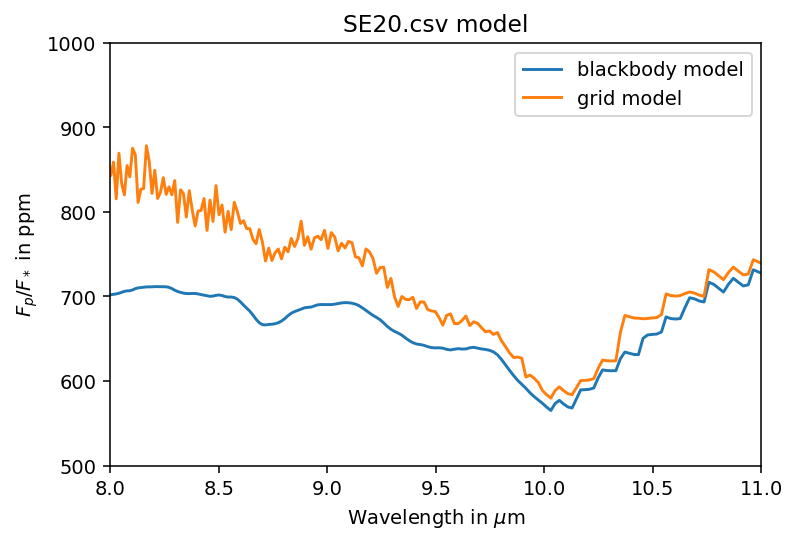

In [17]:
plt.figure()
plt.plot(wav_eps, 10**6*model_bb_star, label='blackbody model')
plt.plot(wav_eps, 10**6*model_grid_star, label='grid model')
plt.xlabel('Wavelength in $\mu$m')
plt.ylabel('$F_p/F_*$ in ppm')
plt.title(file_name + ' model')
plt.ylim((500,1000))
plt.xlim((8,11))
plt.legend()

In [3]:
10/0.35


28.571428571428573